In [1]:
import importlib

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
from shapely.geometry import Polygon

import bento as bt


In [2]:
mpl.style.use("seaborn-white")

In [3]:
adata = bt.io.read_h5ad(
    "/projects/ps-yeolab5/spatial-tx/internal/external_datasets/Xenium_FFPE_Human_Breast_Cancer_rep1/Xenium_FFPE_Human_Breast_Cancer_Rep1_bento.h5ad"
)


In [4]:
adata

AnnData object with n_obs × n_vars = 166482 × 541
    obs: 'cell_shape', 'nucleus_shape', 'batch'
    uns: 'points'

In [21]:
sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)


In [22]:
bt.tl.analyze_shapes(adata, shape_names=["cell"], feature_names="area")


  0%|          | 0/1 [00:00<?, ?it/s]

Text(0, 0.5, 'n_genes_by_counts')

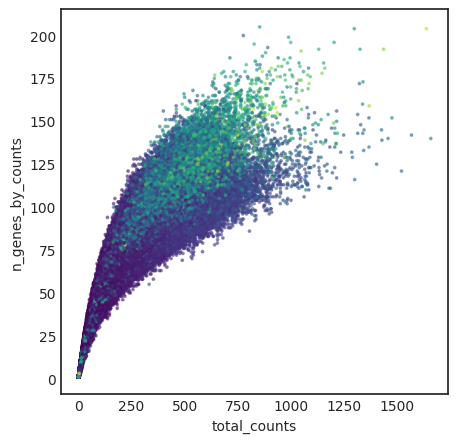

In [ ]:
plt.figure(figsize=(5, 5))
plt.scatter(
    x=adata.obs["total_counts"],
    y=adata.obs["n_genes_by_counts"],
    c=adata.obs["cell_area"],
    s=3,
    alpha=0.5,
    cmap="viridis",
)
plt.xlabel("total_counts")
plt.ylabel("n_genes_by_counts")


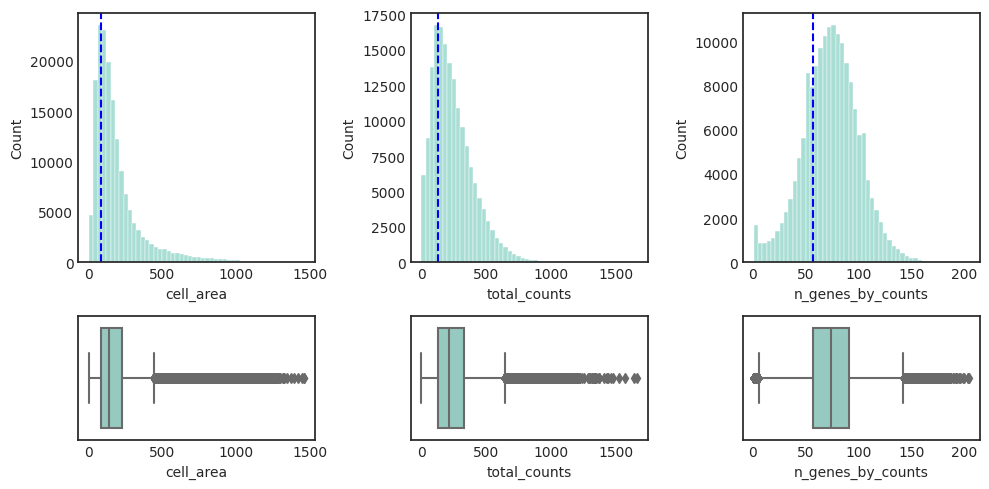

In [ ]:
# Plot histogram of cell area, total counts, and n_genes_by_counts in subplots. Draw boxplots underneath each histogram.
fig, axes = plt.subplots(2, 3, figsize=(10, 5), gridspec_kw={"height_ratios": [2, 1]})

for i, (feature, ax) in enumerate(
    zip(["cell_area", "total_counts", "n_genes_by_counts"], axes[0])
):
    sns.histplot(adata.obs[feature], ax=ax, bins=50)
    ax.axvline(np.quantile(adata.obs[feature], 0.25), c="blue", ls="--")

for i, (feature, ax) in enumerate(
    zip(["cell_area", "total_counts", "n_genes_by_counts"], axes[1])
):
    sns.boxplot(x=adata.obs[feature], ax=ax, orient="h")
    ax.set_xlabel(feature)

plt.tight_layout()


In [ ]:
adata = adata[adata.obs["cell_area"] > np.quantile(adata.obs["cell_area"], 0.25)]
sc.pp.filter_cells(adata, min_counts=np.quantile(adata.obs["total_counts"], 0.25))
adata = adata[
    adata.obs["n_genes_by_counts"] > np.quantile(adata.obs["n_genes_by_counts"], 0.25)
]


In [ ]:
adata.layers['log'] = sc.pp.log1p(adata.X)
sc.pp.highly_variable_genes(adata, layer='log')
sc.pl.highly_variable_genes(adata)

ValueError: Bin edges must be unique: array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan]).
You can drop duplicate edges by setting the 'duplicates' kwarg

In [10]:
adata = bt.geo.crop(adata, (200, 500), (200, 500))


In [27]:
plt.figure(figsize=(8, 8))
bt.pl.density(adata, binwidth=2, cmap=bt.colors.red_dark, title="Transcript Density")


In [12]:
importlib.reload(bt.tl._flux)
importlib.reload(bt.tl)
importlib.reload(bt)

dx = 0.2125
res = 1
radius=0.5
bt.settings.log.setLevel("WARNING")

bt.tl.flux(adata, radius=radius, train_size=0.5, res=res, use_highly_variable=False)

  0%|          | 0/645 [00:00<?, ?it/s]

Text(0.5, 1.0, 'r=0.5')

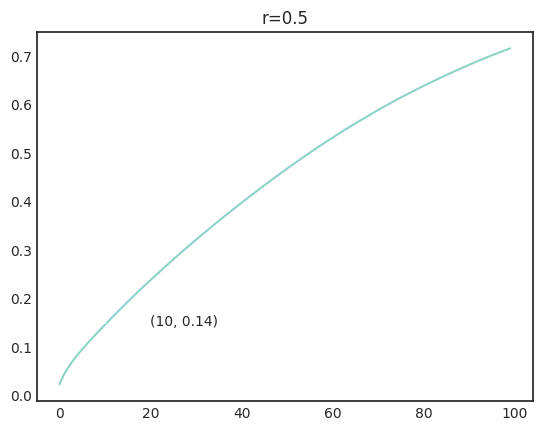

In [13]:
plt.plot(np.cumsum(adata.uns["flux_variance_ratio"]))
ax = plt.gca()
elbow = adata.uns["flux_n_components"]
cumvar = np.sum(adata.uns["flux_variance_ratio"][: elbow + 1])
ax.axvline(elbow, ls="--")
ax.text(elbow + 10, cumvar, f"({elbow}, {cumvar:.2f})")
ax.set_title(f"r={radius}")

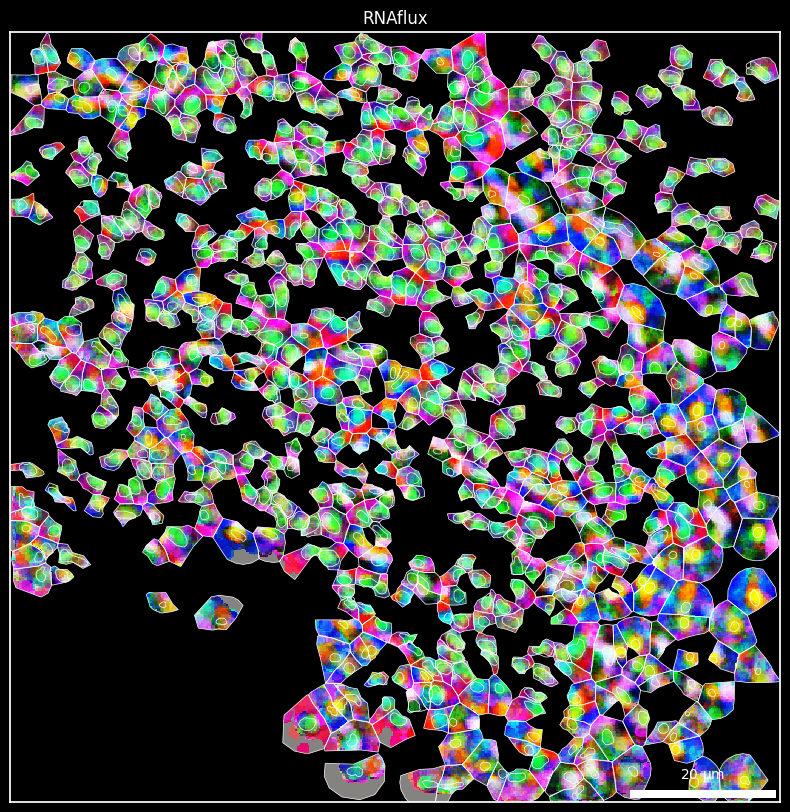

In [28]:
plt.figure(figsize=(10,10))
ax = bt.pl.flux(adata, res=res, dims=[0, 1, 2], alpha=False, dx=dx, title="RNAflux")


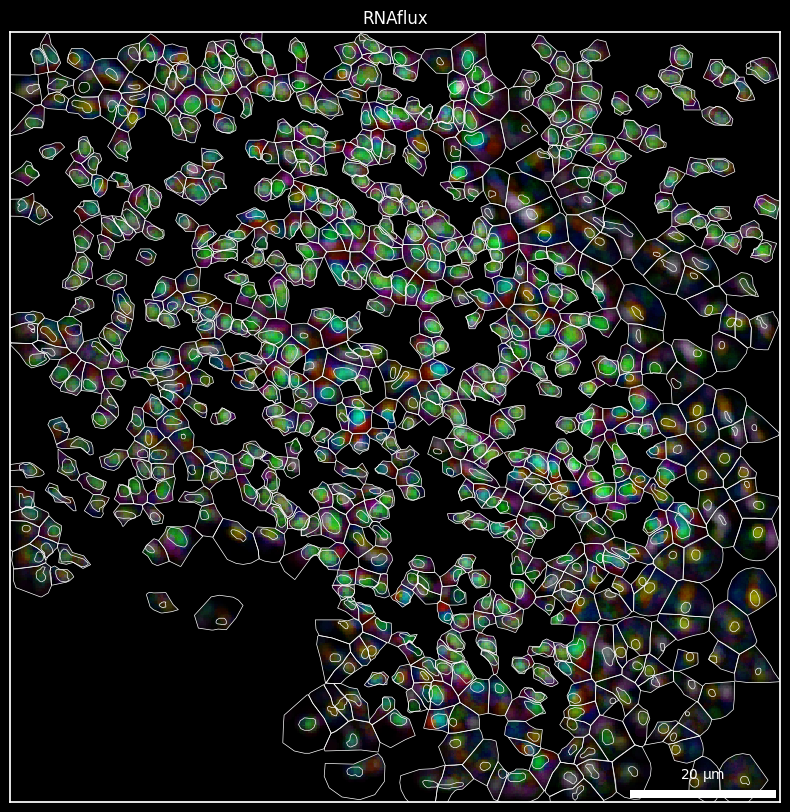

In [29]:
plt.figure(figsize=(10,10))
ax = bt.pl.flux(adata, res=res, dims=[0, 1, 2], alpha=True, dx=dx, title="RNAflux")
# break


<Axes: >

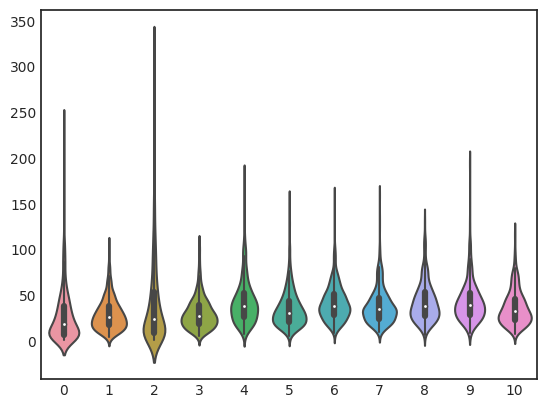

In [16]:
cell_flux = pd.DataFrame(adata.uns["flux_embed"][:, :11]).groupby(
    adata.uns["cell_raster"]["cell"]
)
intra_var = cell_flux.var()
inter_var = cell_flux.mean().var()

sns.violinplot(data=intra_var / inter_var, ax=ax)


In [17]:
bt.tl.fluxmap(adata, n_clusters=range(2,20), min_points=0, res=res, train_size=1)


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

  0%|          | 0/645 [00:00<?, ?it/s]

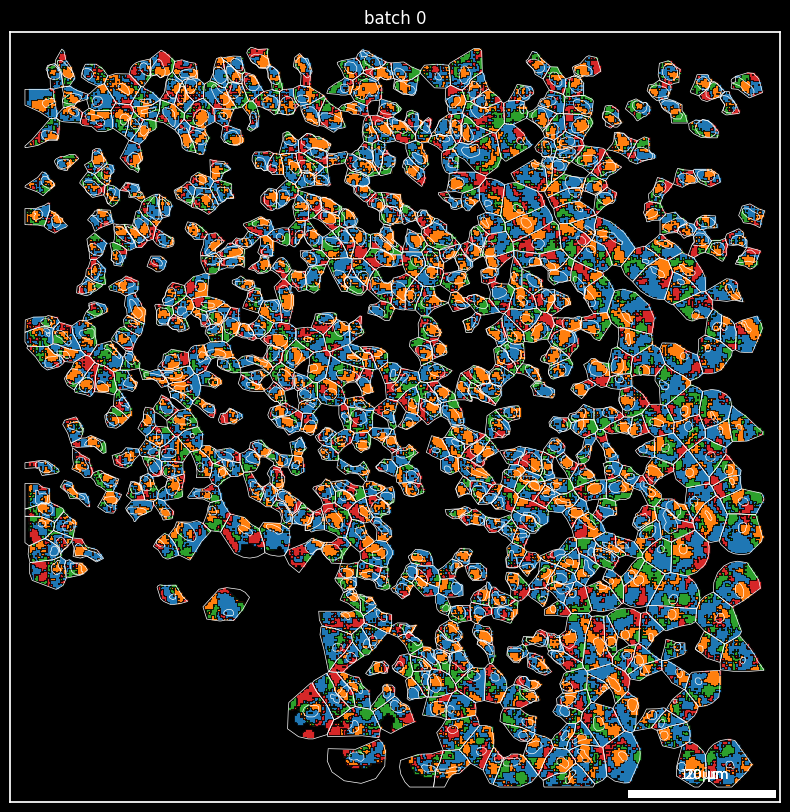

In [30]:
fig = plt.figure(figsize=(10, 10))
bt.pl.fluxmap(adata, dx=dx)

In [42]:
adata.uns['comp_stats'] = bt.tl._composition._get_compositions(adata.uns['points'], ["fluxmap1_shape", "fluxmap2_shape", "fluxmap3_shape", "fluxmap4_shape"])

[15:06:03] WARNING  No artists with labels found to put in legend.  Note that artists whose label    ]8;id=481056;file:///home/ckmah/miniconda3/envs/bentov2/lib/python3.9/site-packages/matplotlib/legend.py\legend.py]8;;\:]8;id=776992;file:///home/ckmah/miniconda3/envs/bentov2/lib/python3.9/site-packages/matplotlib/legend.py#1323\1323]8;;\
                    start with an underscore are ignored when legend() is called with no argument.                 

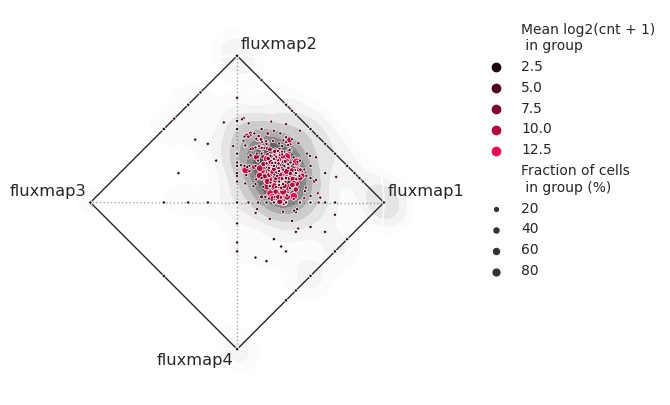

In [ ]:
importlib.reload(bt.pl._multidimensional)
importlib.reload(bt.pl)

with sns.axes_style('white'):
    bt.pl.flux_summary(adata)

In [60]:
adata.uns["cell_raster"]["fluxmap"].value_counts()

1    54292
2    32192
3    21650
4    19230
0     1430
Name: fluxmap, dtype: int64

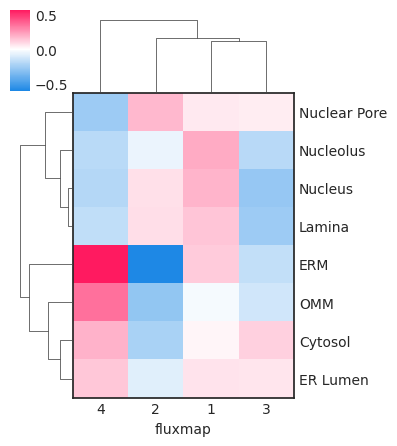

In [62]:
def plot_domain_fe(data, fname=None):
    domains = [
        "flux_Cytosol",
        "flux_Nucleus",
        "flux_ERM",
        "flux_Nucleolus",
        "flux_ER Lumen",
        "flux_OMM",
        "flux_Nuclear Pore",
        "flux_Lamina",
    ]

    domain_fe = pd.DataFrame(
        np.stack([data.uns[d] for d in domains], axis=1),
        index=data.uns["cell_raster"].index,
        columns=domains,
    )

    domain_fe = domain_fe.groupby(data.uns["cell_raster"]["fluxmap"]).mean()
    domain_fe.columns = [d.split("flux_")[1] for d in domain_fe.columns]
    domain_fe = domain_fe.dropna(axis=0)

    with sns.axes_style("white"):
        g = sns.clustermap(
            domain_fe.T,
            center=0,
            cmap=bt.colors.red2blue,
            figsize=(4, 4.5),
        )
        g.ax_heatmap.spines[:].set_visible(True)

plot_domain_fe(adata)

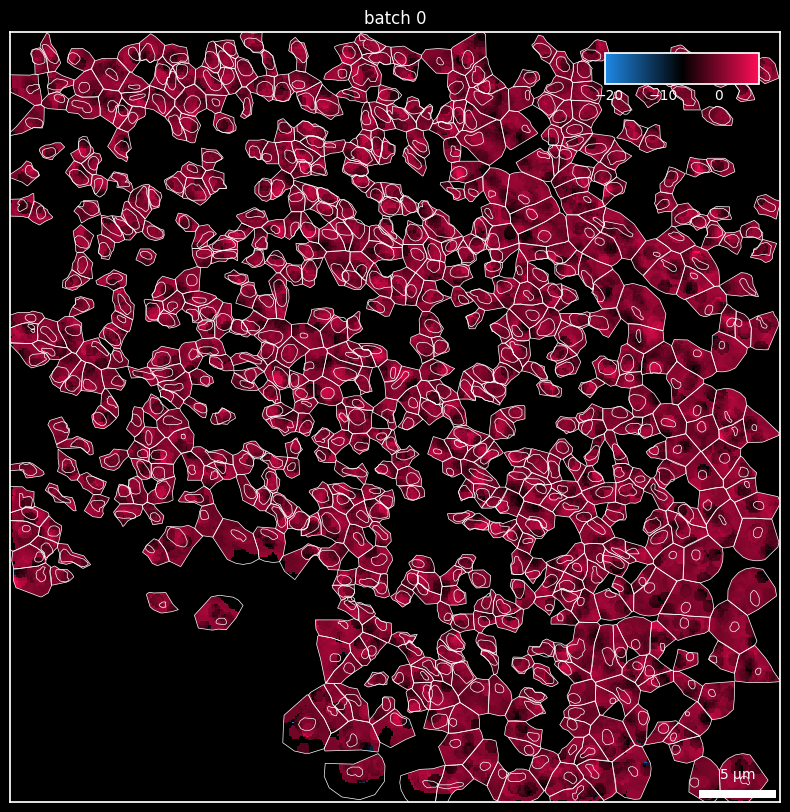

In [ ]:
plt.figure(figsize=(10,10))
bt.pl.fe(adata, 'flux_Nucleus')

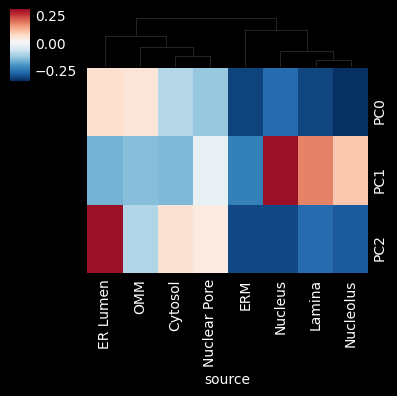

In [31]:
pc_weights = pd.DataFrame(
    adata.uns["flux_sv"][:3],
    index=[f"PC{i}" for i in range(3)],
    columns=adata.uns["flux_genes"],
).T

import decoupler as dc

genesets = bt.tl.load_gene_sets("fazal2019")
genesets = genesets.pivot(index="source", columns="target", values="weight").T.fillna(0)
genesets.head()

common_genes = set(genesets.index).intersection(set(pc_weights.index))

all_df = pd.concat([pc_weights.loc[common_genes], genesets.loc[common_genes]], axis=1)

pc2genesets = all_df.corr(method="spearman").loc[pc_weights.columns, genesets.columns]
sns.clustermap(pc2genesets, cmap="RdBu_r", center=0, figsize=(4, 4), row_cluster=False)


<Axes: >

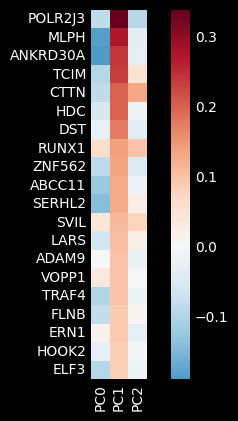

In [32]:
sns.heatmap(
    pc_weights.sort_values("PC1", ascending=False).head(20),
    cmap="RdBu_r",
    center=0,
    square=True,
)


In [33]:
bt.tl.fe_fazal2019(adata)

1430 samples of mat are empty, they will be removed.
Running wsum on mat with 127364 samples and 531 targets for 8 sources.
Infering activities on 13 batches.


  8%|█████████████▏                                                                                                                                                              | 1/13 [00:02<00:35,  2.96s/it]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:36<00:00,  2.77s/it]


In [34]:
adata.uns_keys()

['cell_raster',
 'fe_ngenes',
 'fe_stats',
 'flux',
 'flux_Cytosol',
 'flux_ER Lumen',
 'flux_ERM',
 'flux_Lamina',
 'flux_Nuclear Pore',
 'flux_Nucleolus',
 'flux_Nucleus',
 'flux_OMM',
 'flux_counts',
 'flux_embed',
 'flux_genes',
 'flux_n_components',
 'flux_sv',
 'flux_variance_ratio',
 'hvg',
 'point_sets',
 'points']

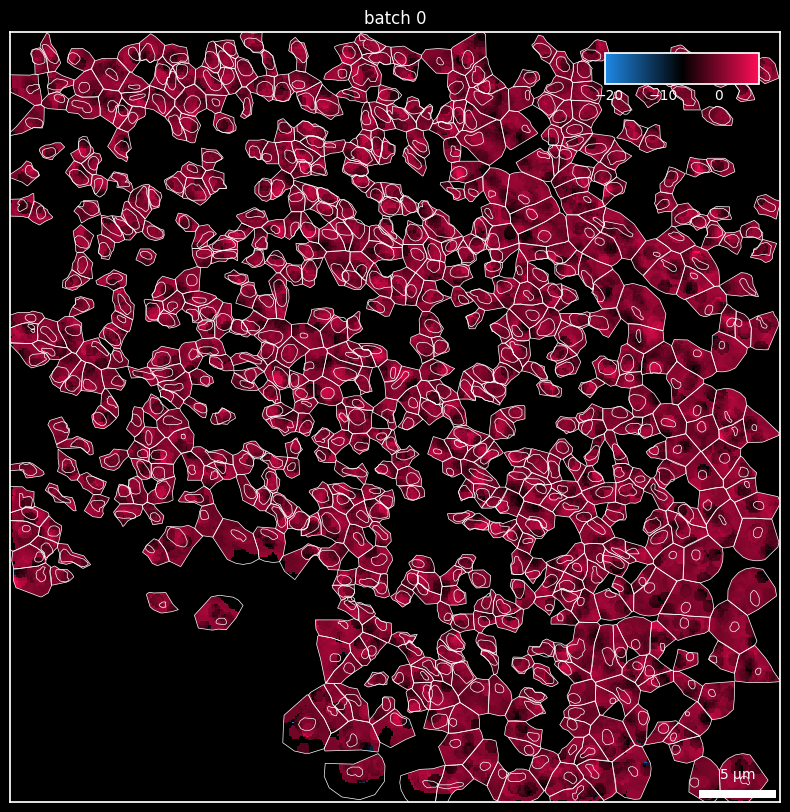

In [35]:
plt.figure(figsize=(10,10))
bt.pl.fe(adata, 'flux_Nucleus')

In [36]:
plt.figure(figsize=(10,10))
bt.pl.fe(adata, 'flux_ER Lumen')

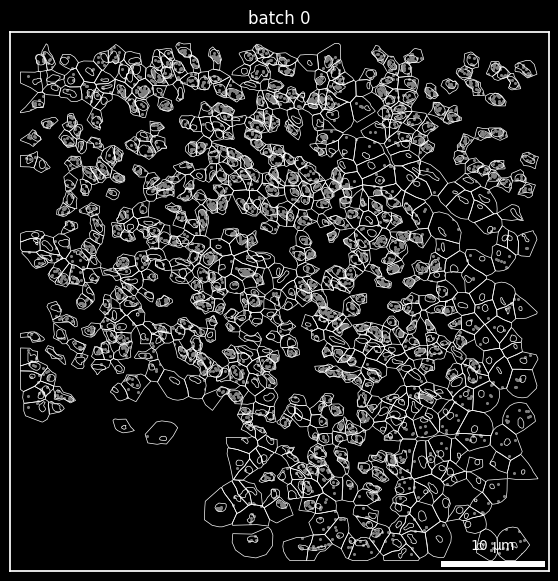

In [37]:
plt.figure(figsize=(7, 7))
bt.pl.points(adata[:, 'MLPH'], s=5)
